<a href="https://colab.research.google.com/github/Ahmed-Magdi1/2DOF-Helicopter-NARX/blob/v.1/NARX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Important libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

In [2]:
# Load input and output CSV files
inputs = pd.read_csv('input.csv')  # Contains: V, I_pitch, I_yaw
outputs = pd.read_csv('output.csv')  # Contains: pitch_angle, yaw_angle

# Convert to arrays
X = inputs.values  # Shape: (samples, features)
Y = outputs.values  # Shape: (samples, targets)

##Normalize the Data

In [3]:
# Create scalers for inputs and outputs
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Fit and transform the data
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

##Lagged Features

In [4]:
def create_lagged_data(inputs, outputs, input_lag, output_lag):
    X_lagged, Y_lagged = [], []
    for t in range(max(input_lag, output_lag), len(inputs)):
        x_lagged = inputs[t-input_lag:t].flatten()  # Lagged inputs
        y_lagged = outputs[t-output_lag:t-1].flatten()  # Lagged outputs
        X_lagged.append(np.hstack((x_lagged, y_lagged)))  # Combine input-output lags
        Y_lagged.append(outputs[t])  # Current output
    return np.array(X_lagged), np.array(Y_lagged)

##Lagged Data

In [5]:
# Define input and output lags
input_lag = 3  # Number of past input time steps to use
output_lag = 2  # Number of past output time steps to use

# Generate lagged data
X_lagged, Y_lagged = create_lagged_data(X_scaled, Y_scaled, input_lag, output_lag)

# Split the lagged data
X_train, X_test, Y_train, Y_test = train_test_split(X_lagged, Y_lagged, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

##Define the Feedforward Neural Network

In [6]:
# Define the NARX neural network
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),  # Input: lagged features
    Dense(128, activation='relu'),
    Dense(Y_train.shape[1], activation='linear')  # Output: pitch and yaw angles
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,346 (36.51 KB)

 Trainable params: 9,346 (36.51 KB)

 Non-trainable params: 0 (0.00 B)

##Train the Model

In [7]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0149 - mae: 0.0393 - val_loss: 2.2869e-05 - val_mae: 0.0031
Epoch 2/100
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.6102e-05 - mae: 0.0025 - val_loss: 9.5383e-06 - val_mae: 0.0013
Epoch 3/100
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.9849e-05 - mae: 0.0029 - val_loss: 2.8885e-05 - val_mae: 0.0045
Epoch 4/100
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.3511e-05 - mae: 0.0031 - val_loss: 1.4091e-05 - val_mae: 0.0028
Epoch 5/100
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.3517e-05 - mae: 0.0031 - val_loss: 2.2528e-05 - val_mae: 0.0039
Epoch 6/100
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.9293e-05 - mae: 0.0029 - val_loss: 1.3072e-05 - val_mae: 0.0026
Epoch 7/100
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.3609e-05 - mae: 0.0025 - val_loss: 1.9898e-05 - val_mae: 0.0030
Epoch 8/100
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.3556e-05 - mae: 0.0025 - val_loss:

##Evaluate the Model

In [8]:
loss, mae = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4094e-06 - mae: 0.0014
Test Loss: 4.426747636898654e-06, Test MAE: 0.0014260731404647231


##Predictions

In [12]:
# Predict on test set
Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual outputs
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_actual = scaler_Y.inverse_transform(Y_test)

# Compare predictions and actual values

# Create a comparison DataFrame
comparison = pd.DataFrame({
    'Predicted Pitch': Y_pred[:, 0],
    'Actual Pitch': Y_actual[:, 0],
    'Predicted Yaw': Y_pred[:, 1],
    'Actual Yaw': Y_actual[:, 1]
})

# Print the first 30 rows of the comparison
print(comparison.head(60))

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
    Predicted Pitch  Actual Pitch  Predicted Yaw  Actual Yaw
0         61.002865         61.00     -35.323402      -35.25
1         60.771667         60.75     -32.796680      -33.00
2         60.813026         60.75     -30.039698      -30.00
3         60.809776         60.75     -33.057167      -33.00
4         60.789940         60.75     -36.323090      -36.00
5         60.816586         60.75     -30.544731      -30.50
6         60.789757         60.75     -33.559177      -33.50
7         60.985371         61.00     -38.083496      -38.00
8         60.789970         60.75     -34.063896      -34.00
9         60.790588         60.75     -34.313282      -34.25
10        61.068405         61.00     -26.024500      -25.75
11        60.829781         60.75     -30.553288      -30.25
12        61.008881         61.00     -32.059696      -32.00
13        60.809059         60.75     -32.304497      -32.25
14        60.991558         61.00     -34.06

##Visualize Results

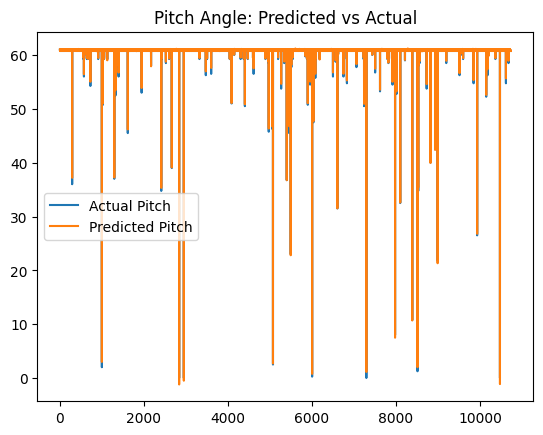

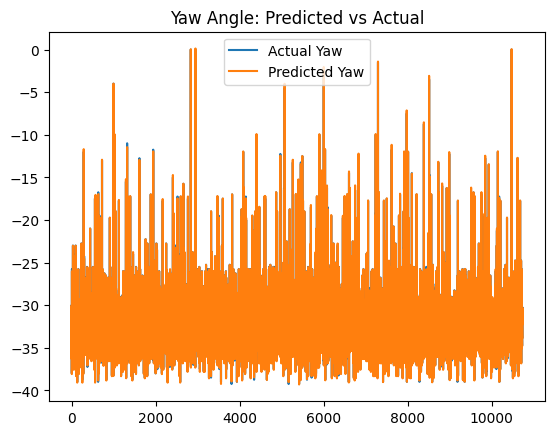

In [13]:
# Plot pitch predictions
plt.figure()
plt.plot(Y_actual[:, 0], label='Actual Pitch')
plt.plot(Y_pred[:, 0], label='Predicted Pitch')
plt.legend()
plt.title('Pitch Angle: Predicted vs Actual')
plt.show()

# Plot yaw predictions
plt.figure()
plt.plot(Y_actual[:, 1], label='Actual Yaw')
plt.plot(Y_pred[:, 1], label='Predicted Yaw')
plt.legend()
plt.title('Yaw Angle: Predicted vs Actual')
plt.show()

In [14]:
# Calculate MAE
mae_pitch = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
mae_yaw = mean_absolute_error(Y_actual[:, 1], Y_pred[:, 1])

# Calculate RMSE
rmse_pitch = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
rmse_yaw = np.sqrt(mean_squared_error(Y_actual[:, 1], Y_pred[:, 1]))

# Print metrics
print(f"Pitch MAE: {mae_pitch}, Pitch RMSE: {rmse_pitch}")
print(f"Yaw MAE: {mae_yaw}, Yaw RMSE: {rmse_yaw}")

Pitch MAE: 0.046824800761602926, Pitch RMSE: 0.07207878611081402
Yaw MAE: 0.08181775669623337, Yaw RMSE: 0.10718392085716155


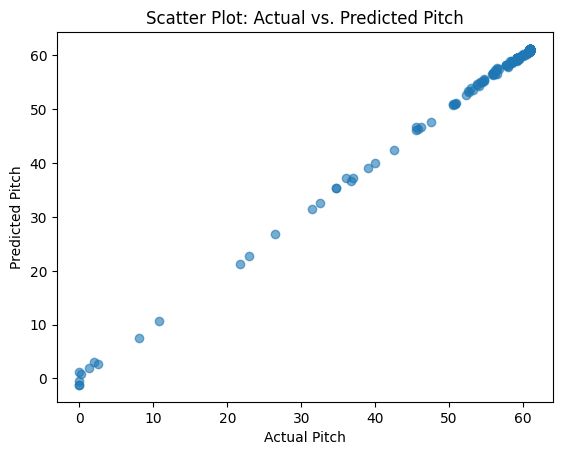

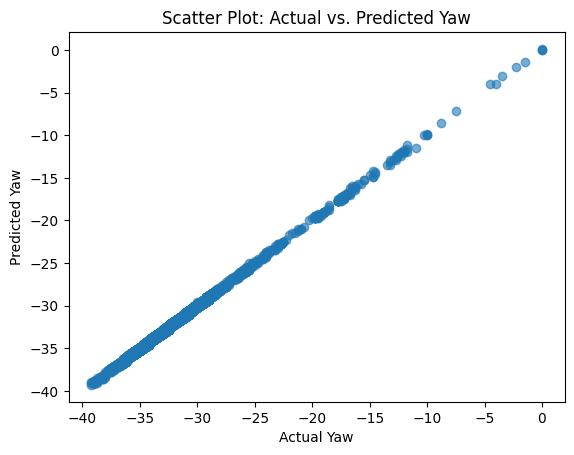

In [15]:
# Scatter plot for Pitch
plt.figure()
plt.scatter(Y_actual[:, 0], Y_pred[:, 0], alpha=0.6)
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Scatter Plot: Actual vs. Predicted Pitch')
plt.show()

# Scatter plot for Yaw
plt.figure()
plt.scatter(Y_actual[:, 1], Y_pred[:, 1], alpha=0.6)
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Scatter Plot: Actual vs. Predicted Yaw')
plt.show()

In [16]:
# Compile the model with full names for loss and metrics
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Save the model
model.save('NARX_helicopter_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
model = load_model('narx_helicopter_model.h5')
print("Model loaded successfully.")

Model loaded successfully.
